In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import networkx as nx

In [15]:
import pandas as pd

In [16]:
from mentor_matching import reduce_full_tables

In [17]:
names_df = pd.read_csv('name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')
names_df.head()

,Faculty,Faculty_initials,Postdocs,Postdocs_initials,GradStudents,Grad_initials,Undergrads,Undergrad_initials
0,Lilly Norton,AMG,Christiana Buckner,ABG,Subhaan Walsh,AMG,Maira Nava,NK
1,Anand Coulson,AMG,Yusuf Lucas,AMG,Amaan Terry,ABG,Marius Beil,AMG
2,Ruby-Leigh Holloway,AMG,Indigo Cope,AMG,Brennan Stanton,AMG,Khia Galindo,AMG
3,Kacie Chandler,AMG,Felicity Vo,ZD,Quinn Cobb,ABG,Willem Swan,TS
4,Iosif Chaney,TS,Alexander Mitchell,NK,Hannah Rivas,TS,Harris Bryan,ABG


In [18]:
mentees_df = pd.read_csv('mentees.csv')
#mentees_df.head()

In [19]:
mentors_df = pd.read_csv('mentors.csv')
#mentors_df.head()

In [20]:
people = reduce_full_tables(names_df,mentees_df,mentors_df)

In [21]:
for person in list(people.values())[::6][:10]:
    person.print_preferences()

Faculty: LillyNorton
nmentors: 0 [0. 0. 0. 0.]
nmentees: 3 [1. 1. 1. 0.] (2)
------
avoid  mentees: ['SubhaanWalsh', 'MairaNava']
avoid  mentors: []
------
prefer mentees: ['ChristianaBuckner']
prefer mentors: []
------

Faculty: AshleeWeir
nmentors: 0 [0. 0. 0. 0.]
nmentees: 0 [0. 0. 0. 0.] (1)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Postdocs: IndigoCope
nmentors: 1 [0. 0. 0. 1.]
nmentees: 0 [0. 0. 0. 0.] (0)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: []
------

Postdocs: MehreenPearson
nmentors: 2 [0. 0. 1. 1.]
nmentees: 4 [1. 2. 1. 0.] (2)
------
avoid  mentees: ['IosifChaney']
avoid  mentors: ['IosifChaney', 'LukasLeech']
------
prefer mentees: []
prefer mentors: []
------

Postdocs: CohenO'Moore
nmentors: 4 [0. 0. 2. 2.]
nmentees: 4 [0. 4. 0. 0.] (3)
------
avoid  mentees: []
avoid  mentors: []
------
prefer mentees: []
prefer mentors: ['PiotrBernal']
------

GradStudents: HannahR

--------

In [71]:
from mentor_matching import generate_network
from network_metrics import run_all_metrics

In [72]:
nruns = 200
vals = np.zeros((9,nruns))
for i in range(nruns):
    print ('round', i)
    vals[:,i],names = run_all_metrics(*generate_network(names_df,mentees_df,mentors_df,loud=False))

round 0
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStu

Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: Mir

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Evere

cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 13
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: Stan

cliques 9 0
round 22
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Me

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWil

Mentee  GradStudents: ConahClarkson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: ConahClarkson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents:

Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs:

Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: Sta

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Everett

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohn

Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: 

cliques 3 0
cliques 4 0
cliques 5 0
cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 54
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a men

Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Post

Mentee  Undergrads: KhiaGalindo  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdo

cliques 7 0
cliques 8 0
cliques 9 0
round 64
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+

cliques 5 0
cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 68
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AllanOchoa  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson 

cliques 5 0
cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 75
Mentee  GradStudents: ConahClarkson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: ConahClarkson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more th

cliques 1 49
cliques 2 75
cliques 3 3
cliques 4 0
cliques 5 0
cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 79
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells

Mentee  Undergrads: KhiaGalindo  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdo

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Be

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: Meh

Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterK

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudent

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyN

Mentee  Undergrads: MariusBeil  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: S

Mentee  GradStudents: AllanOchoa  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs:

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowel

Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMe

Mentee  Postdocs: MirunaO'Ryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CohenO'Moore  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
cliques 0 0
cliques 1 49
cliques 2 75
cliques 3 5
cliques 4 0
cliques 5 0
cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 120
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Marci

Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MirunaO'Ryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CohenO'Moore  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Hanna

Mentee  Undergrads: MariusBeil  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AllanOchoa  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: HannahRivas  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: 

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AllanOchoa  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston 

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MirunaO'Ryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CohenO'Moore  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Undergrads: MariusBeil  cannot 

Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs:

round 144
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  

Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MirunaO'Ryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CohenO'Moore  

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Evere

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: AmaanTerry  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: B

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNa

Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: QuinnCobb  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Everett

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents

Mentee  GradStudents: BethanyField  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MirunaO'Ryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CohenO'Moore  

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettH

round 180
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MarciaSmith  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents:

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SubhaanWalsh  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudent

cliques 1 49
cliques 2 74
cliques 3 5
cliques 4 0
cliques 5 0
cliques 6 0
cliques 7 0
cliques 8 0
cliques 9 0
round 188
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Ev

Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: Mirun

Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: MirunaO'Ryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CohenO'Moore  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Undergrads: MariusBeil  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Undergrads: HarrisBryan  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  

Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: CharliKirkpatrick  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Faculty: RohaanSawyer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: MaxineJacobson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: Kailum

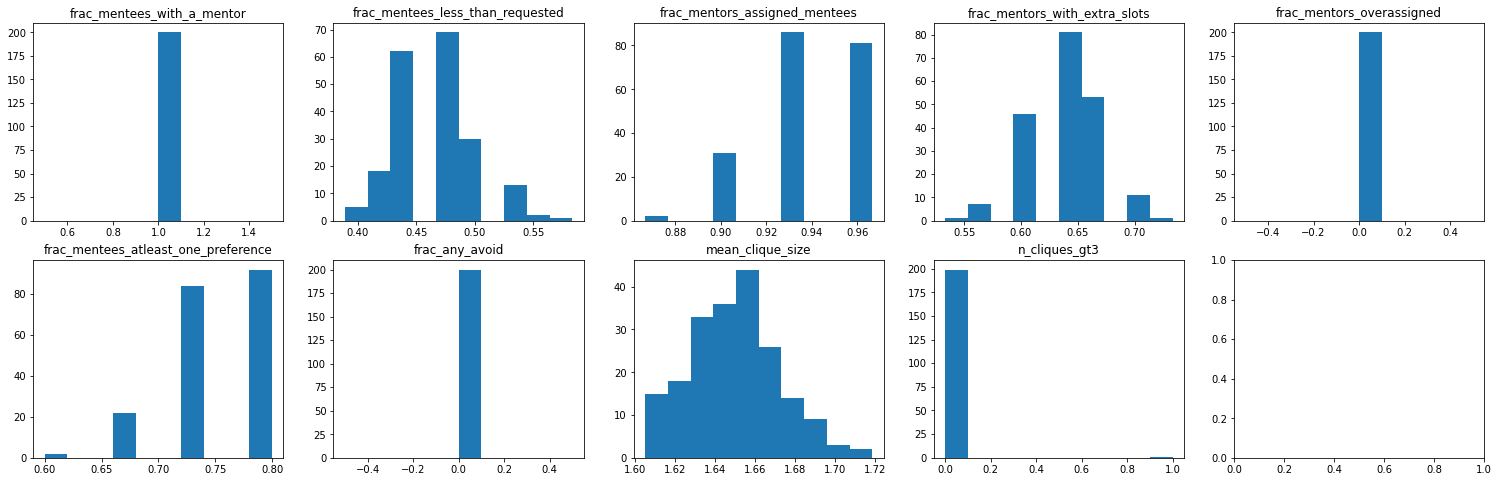

In [73]:
fig,axs = plt.subplots(nrows=2,ncols=5)
for i,ax in enumerate(axs.flatten()):
    if (i < len(vals)):
        ax.hist(vals[i], align = 'mid')
        ax.set_title(names[i])
fig.set_size_inches(26,8)

In [ ]:
# testing a method to pick the best network
# combined_metric = [0]*nruns
# for i in range(nruns):
#     for v in vals:

In [66]:
people,network = generate_network(names_df,mentees_df,mentors_df,loud=False)

Mentee  Postdocs: MehreenPearson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: StanleyNaylor  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: JoseffMercer  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: ChristianaBuckner  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: LesterKenny  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: SaqibJohnston  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: KailumWilkinson  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  GradStudents: EverettHowells  cannot be matched to a mentor any more that satisfies all mentee+mentors requirements!
Mentee  Postdocs: Mehre

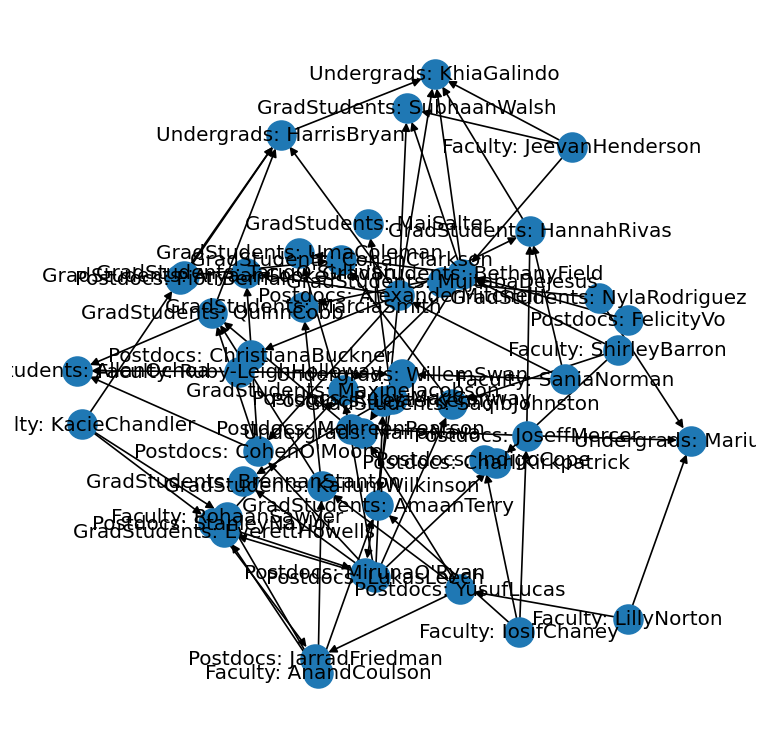

In [67]:
fig,ax = plt.subplots(1,1)
foo = nx.draw_kamada_kawai(network,ax=ax,with_labels=True)
fig.set_size_inches(8,8)
fig.set_dpi(120)